In [143]:
import cv2
import numpy as np
import glob
import json
import os
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import sys
import time
import random
random.seed(time.time())

sys.path.append(os.path.dirname(os.path.abspath('.')))
import utils.frame_slicing as frame_slicing
import utils.frame_concatent as frame_concatent

number_of_squares_x = 11
number_of_internal_corners_x = number_of_squares_x - 1
number_of_squares_y = 8
number_of_internal_corners_y = number_of_squares_y - 1
square_size = 0.023 # in meters
cameras = ['cam2', 'cam3', 'wide', 'cam0', 'cam1']

In [144]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(10,9,0)
objp = np.zeros((number_of_internal_corners_x * number_of_internal_corners_y,3), np.float32)
objp[:,:2] = np.mgrid[0:number_of_internal_corners_x,0:number_of_internal_corners_y].T.reshape(-1,2)
print(objp)

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [7. 0. 0.]
 [8. 0. 0.]
 [9. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [4. 1. 0.]
 [5. 1. 0.]
 [6. 1. 0.]
 [7. 1. 0.]
 [8. 1. 0.]
 [9. 1. 0.]
 [0. 2. 0.]
 [1. 2. 0.]
 [2. 2. 0.]
 [3. 2. 0.]
 [4. 2. 0.]
 [5. 2. 0.]
 [6. 2. 0.]
 [7. 2. 0.]
 [8. 2. 0.]
 [9. 2. 0.]
 [0. 3. 0.]
 [1. 3. 0.]
 [2. 3. 0.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]
 [6. 3. 0.]
 [7. 3. 0.]
 [8. 3. 0.]
 [9. 3. 0.]
 [0. 4. 0.]
 [1. 4. 0.]
 [2. 4. 0.]
 [3. 4. 0.]
 [4. 4. 0.]
 [5. 4. 0.]
 [6. 4. 0.]
 [7. 4. 0.]
 [8. 4. 0.]
 [9. 4. 0.]
 [0. 5. 0.]
 [1. 5. 0.]
 [2. 5. 0.]
 [3. 5. 0.]
 [4. 5. 0.]
 [5. 5. 0.]
 [6. 5. 0.]
 [7. 5. 0.]
 [8. 5. 0.]
 [9. 5. 0.]
 [0. 6. 0.]
 [1. 6. 0.]
 [2. 6. 0.]
 [3. 6. 0.]
 [4. 6. 0.]
 [5. 6. 0.]
 [6. 6. 0.]
 [7. 6. 0.]
 [8. 6. 0.]
 [9. 6. 0.]]


# Get image points
This function is used to get the image points of the chessboard. So the results can be reused during intrinsic calibration and extrinsic calibration.

Parameters:  
    None  
Return:  
    rets: array of boolean values, True if the chessboard is found, False otherwise shape (number of cameras, number of frames)  
    objpoints: array of image points shape (number of frames, number of cameras, number_of_internal_corners_x * number_of_internal_corners_y, 2)  
    shape: tuple of the shape of the image

In [145]:
def get_image_points():
    imgpoints = [] # 2D points in image plane
    objpoints = [] # 3D points in world coordinate system
    rets = [] # boolean values
    
    images = glob.glob('screen_shots/*.png')
    
    shape = (0,0)
    
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        frame1, frame2, frame3, frame4, frame5, frame6 = frame_slicing.slicing_frame(gray)
        frames = [frame1, frame2, frame3, frame4, frame5]
        
        frame_imgpoints = np.zeros((len(frames), number_of_internal_corners_x * number_of_internal_corners_y, 2))
        frame_objpoints = np.zeros((len(frames), number_of_internal_corners_x * number_of_internal_corners_y, 3))
        frame_rets = np.zeros(len(frames), dtype=bool) + True
        
        for i in range(len(frames)):
            frame = frames[i]
            shape = frame.shape
            
            ret, corners = cv2.findChessboardCorners(frame, (number_of_internal_corners_x,number_of_internal_corners_y), None)
            
            if ret == True:
                corners2 = cv2.cornerSubPix(frame, corners, (11,11), (-1,-1), criteria=criteria)
                frame_objpoints[i, :, :] = objp
                frame_imgpoints[i, :, :] = corners2[:, 0, :]
                
                cv2.drawChessboardCorners(frame, (number_of_internal_corners_x,number_of_internal_corners_y), corners2, ret)
                
            else:
                frame_rets[i] = False
                
        imgpoints.append(frame_imgpoints)
        objpoints.append(frame_objpoints)
        rets.append(frame_rets)
        
        frame_with_corners = frame_concatent.concatent_frame(frames)
        cv2.imwrite(f'chessboard_points/{fname.split("/")[-1]}', frame_with_corners)
        
    imgpoints = np.array(imgpoints)
    objpoints = np.array(objpoints)
    rets = np.array(rets)
        
    return rets, imgpoints, objpoints, shape

In [146]:
def intrinsic_calibration(rets, imgpoints, objpoints, shape):
    for camera_name in cameras:
        imgpoints_camera = imgpoints[:, cameras.index(camera_name), :, :]
        objpoints_camera = objpoints[:, cameras.index(camera_name), :, :]
        rets_camera = rets[:, cameras.index(camera_name)]
        imgpoints_camera = imgpoints_camera[rets_camera, :, :]
        objpoints_camera = objpoints_camera[rets_camera, :, :]
        
        number_of_images = len(rets_camera)
        number_of_success_images = np.sum(rets_camera.astype(int))
        
        obj_pts = []
        img_pts = []
        for i in range(number_of_success_images):
            obj_pts.append(objpoints_camera[i, :, :].astype(np.float32))
            img_pts.append(imgpoints_camera[i, :, :].astype(np.float32))
            
        obj_pts = np.array(obj_pts)
        img_pts = np.array(img_pts)        
        
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, shape[::-1], None, None)
        
        with open(f'results/intrinsic_{camera_name}.json', 'w') as f:
            json.dump({'mtx': mtx.tolist(), 'dist': dist.tolist()}, f)
        
        print(f'{camera_name} has {number_of_success_images}/{number_of_images} successful images')
        
        mean_error = 0
        for i in range(number_of_success_images):
            imgpoints2, _ = cv2.projectPoints(obj_pts[i], rvecs[i], tvecs[i], mtx, dist)
            # Reshape imgpoints2 to match img_pts dimensions
            imgpoints2 = imgpoints2.reshape(-1, 2)
            error = cv2.norm(img_pts[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
            mean_error += error
        mean_error = mean_error / number_of_success_images
        print(f'{camera_name} has mean error: {mean_error}')
            
    return

# Project arrows into the image

In [147]:

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel().astype("int32"))
    imgpts = imgpts.astype("int32")
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

def projection(img, mtx, dist):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (number_of_internal_corners_x, number_of_internal_corners_y), None)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria=criteria)
        ret,rvecs, tvecs = cv2.solvePnP(objp, corners2, mtx, dist)
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        img = draw(img, corners2, imgpts)
        
    return img

# Extrinsic calibration

### Transformation Matrix

$$ H = \begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix} 
    = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x \\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

In [148]:
def extrinsic_calibration(mtxs, dists):

    images = glob.glob('screen_shots/*.png')

    effective_chessboard_count = 0
    total_chessboard_count = 0
    
    transformation_matrices = []

    for image in images:
        cameras_ret = True
        if len(image.split('/')[1].split('_')) != 1:
            continue
        
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        frame1, frame2, frame3, frame4, frame5, frame6 = frame_slicing.slicing_frame(gray)
        frames = [frame1, frame2, frame3, frame4, frame5]
        
        transformation_matrix_temp = np.zeros((len(cameras), 4, 4))
        
        for camera in cameras:
            frame = frames[cameras.index(camera)]
            ret, corners = cv2.findChessboardCorners(frame, (number_of_internal_corners_x,number_of_internal_corners_y), None)
        
            if ret == True:
                corners = cv2.cornerSubPix(frame, corners, (11,11), (-1,-1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
                ret, rvec, tvec = cv2.solvePnP(objp, corners, mtxs[cameras.index(camera)], dists[cameras.index(camera)])
                
                imgpts, _ = cv2.projectPoints(objp, rvec, tvec, mtxs[cameras.index(camera)], dists[cameras.index(camera)])
                frame = draw(frame,corners,imgpts)
                cv2.imwrite(f'reprojection/img_f{image.split("/")[1]}_{camera}.png', frame)
                
                R, _ = cv2.Rodrigues(rvec)
                # The rvec and tvec are the object points in the camera coordinate system
                transformation_matrix_temp[cameras.index(camera), :3, :3] = R
                transformation_matrix_temp[cameras.index(camera), :3, 3] = tvec.T[0]
                transformation_matrix_temp[cameras.index(camera), 3, 3] = 1
                # Find the inverse matrix so we can find the object points of the camera relative to the chessboard
                transformation_matrix_temp[cameras.index(camera), :, :] = np.linalg.inv(transformation_matrix_temp[cameras.index(camera), :, :])
            else:
                cameras_ret = False
            
        if cameras_ret:
            transformation_matrices.append(transformation_matrix_temp)
            effective_chessboard_count += 1
        
        total_chessboard_count += 1
        
    print(f'Effective Chessboard: {effective_chessboard_count}/{total_chessboard_count}')
    transformation_matrices = np.array(transformation_matrices)
    # The transformation matrices are the transformation matrix from the chessboard to the camera
    return transformation_matrices

In [149]:
def set_origin(transformation_matrices):
    for i in range(transformation_matrices.shape[0]):
        chess_board_transformation_matrix = np.linalg.inv(transformation_matrices[i, 2, :, :])
        transformation_matrices[i, 0, :, :] = transformation_matrices[i, 0, :, :] @ chess_board_transformation_matrix
        transformation_matrices[i, 1, :, :] = transformation_matrices[i, 1, :, :] @ chess_board_transformation_matrix
        transformation_matrices[i, 3, :, :] = transformation_matrices[i, 3, :, :] @ chess_board_transformation_matrix
        transformation_matrices[i, 4, :, :] = transformation_matrices[i, 4, :, :] @ chess_board_transformation_matrix
        transformation_matrices[i, 2, :, :] = np.zeros((4, 4))
        transformation_matrices[i, 2, 3, 3] = 1
    return transformation_matrices

In [150]:
def remove_outliers(transformation_matrices):
    # TODO: Remove outliers
    transformation_matrices = transformation_matrices[0, :, :, :]
    return transformation_matrices

In [151]:
def visualize(transformation_matrices):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(2, 3, 1, projection='3d')
    for i in range(len(transformation_matrices)):
        orientation = np.array([1, 0, 0]) @ transformation_matrices[i, :3, :3]
        ax.quiver(transformation_matrices[i, 3, 0], transformation_matrices[i, 3, 1], transformation_matrices[i, 3, 2], orientation[0], orientation[1], orientation[2], color = 'red', length=0.1)
        
    return fig

# Pipeline-Intrinsic

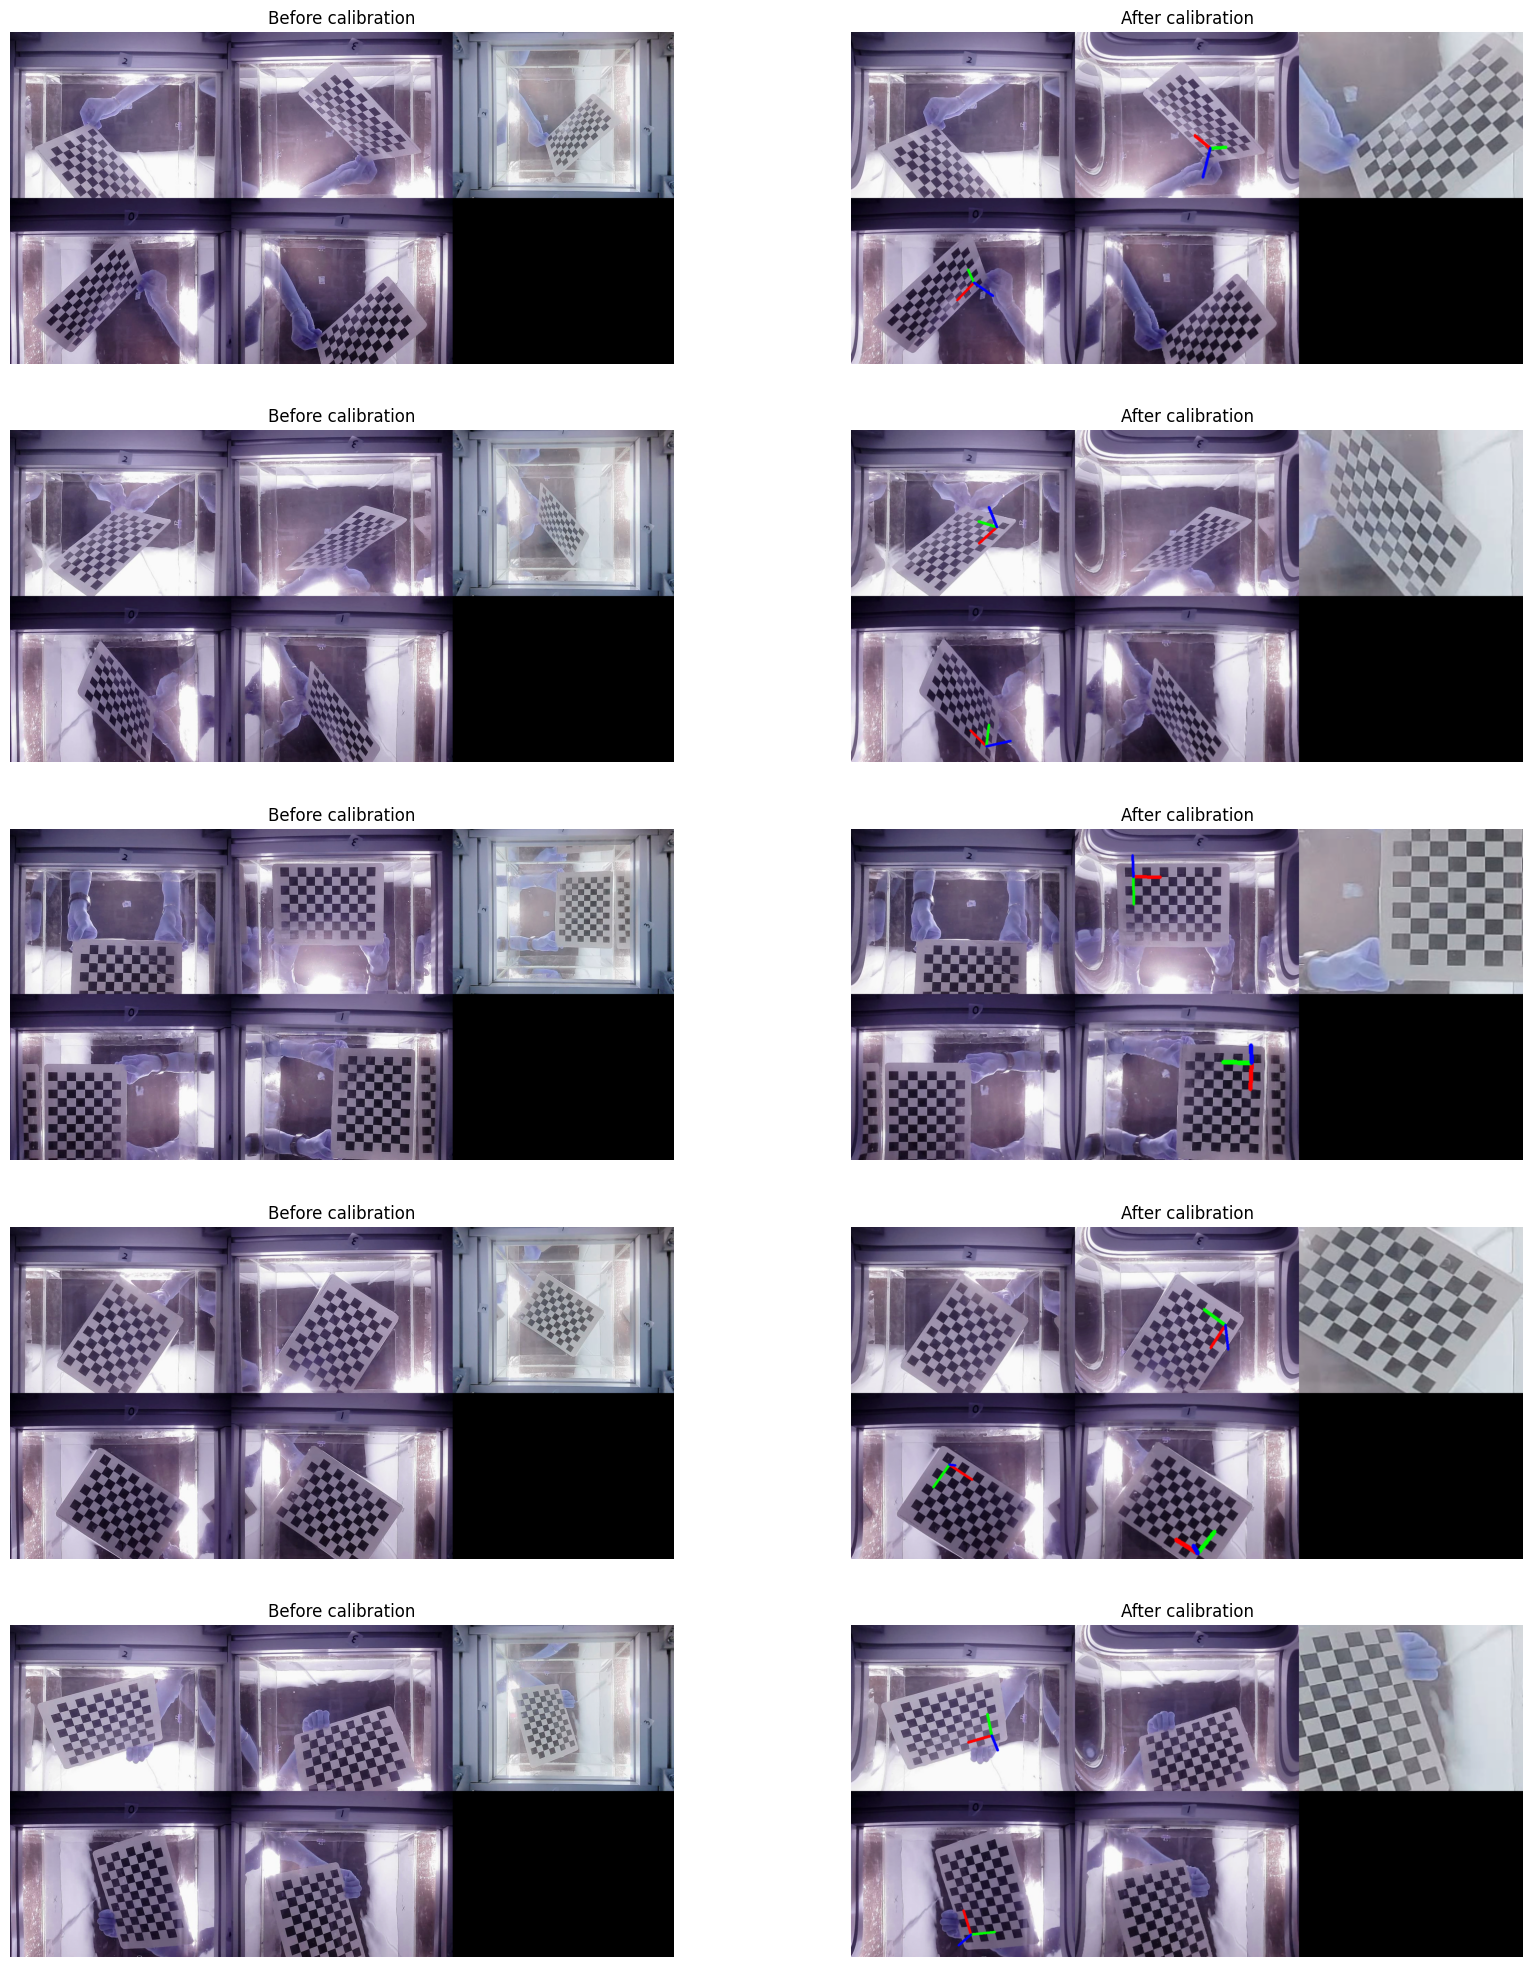

In [152]:
if os.path.exists('results/rets.json') and os.path.exists('results/object_points.json') and os.path.exists('results/image_points.json') and os.path.exists('results/shape.json'):
    with open('results/rets.json', 'r') as f:
        rets = np.array(json.load(f))
    with open('results/object_points.json', 'r') as f:
        objpoints = np.array(json.load(f))
    with open('results/image_points.json', 'r') as f:
        imgpoints = np.array(json.load(f))
    with open('results/shape.json', 'r') as f:
        shape = tuple(json.load(f))
else:
    rets, imgpoints, objpoints, shape = get_image_points()
    with open('results/rets.json', 'w') as f:
        json.dump(rets.tolist(), f)
    with open('results/object_points.json', 'w') as f:
        json.dump(objpoints.tolist(), f)
    with open('results/image_points.json', 'w') as f:
        json.dump(imgpoints.tolist(), f)
    with open('results/shape.json', 'w') as f:
        json.dump(shape, f)
        
results = os.listdir('results')
if 'intrinsic_cam0.json' in results and 'intrinsic_cam1.json' in results and 'intrinsic_cam2.json' in results and 'intrinsic_cam3.json' in results and 'intrinsic_wide.json' in results:
    pass
else:
    intrinsic_calibration(rets, imgpoints, objpoints, shape)
    
mtxs = []
dists = []
for i in range(5):
    with open(f'results/intrinsic_{cameras[i]}.json', 'r') as f:
        data = json.load(f)
        mtx = np.array(data['mtx'])
        dist = np.array(data['dist'])
        mtxs.append(mtx)
        dists.append(dist)
        
fig = plt.figure(figsize=(20, 25))

for i in range(5):
    images = os.listdir('screen_shots')
    random_index = random.randint(0, len(images) - 1)
    image = cv2.imread(f'screen_shots/{images[random_index]}')
    ax = fig.add_subplot(5, 2, i * 2 + 1)
    ax.imshow(image)
    ax.set_title(f'Before calibration')
    ax.axis('off')
    
    frame1, frame2, frame3, frame4, frame5, frame6 = frame_slicing.slicing_frame(image)
    frames = [frame1, frame2, frame3, frame4, frame5]
    
    for j in range(len(frames)):
        frame = frames[j] 
        h,  w = frame.shape[:2]
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtxs[j], dists[j], (w,h), 1, (w,h))
        dst = cv2.undistort(frame, mtxs[j], dists[j], None, newcameramtx)
        x, y, w, h = roi
        frame = dst[y:y+h, x:x+w]
        frames[j] = projection(frame, mtxs[j], dists[j])
        
    images_after_calibration = frame_concatent.concatent_frame(frames)
    ax = fig.add_subplot(5, 2, i * 2 + 2)
    ax.imshow(images_after_calibration)
    ax.set_title(f'After calibration')
    ax.axis('off')
        
plt.show()